In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

## データ生成

In [2]:
SEED = 1234
rng = np.random.default_rng(seed=SEED)

In [3]:
N = 100
x = 2.0 * np.pi * np.arange(N) / N
y = rng.normal(loc=np.sin(x), scale=0.1)

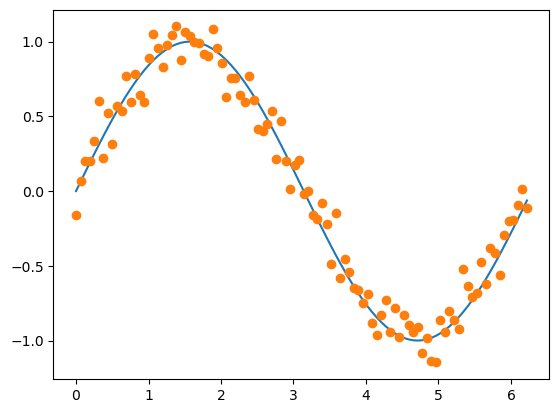

In [4]:
(fig, ax) = plt.subplots()
ax.plot(x, np.sin(x), zorder=0)
ax.scatter(x, y, color="C1", zorder=1)
plt.show()

## モデル化

In [5]:
from sklearn.mixture import GaussianMixture

class GaussianMixtureRegressor:
    
    def __init__(self, *args, dim_x=1, dim_y=1, **kwargs):
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.gmm = GaussianMixture(*args, **kwargs)
    
    def train(self, X, Y):
        X = np.asarray(X)
        Y = np.asarray(Y)
        if X.ndim == 1:
            X = X[:, np.newaxis]
        if Y.ndim == 1:
            Y = Y[:, np.newaxis]
        assert X.shape[-1] == self.dim_x and Y.shape[-1] == self.dim_y
        self.gmm.fit(np.hstack((X, Y)))
    
    def _conditional_mean(self, X, mu_X, mu_Y, Sigma_XX, Sigma_YX):
        Z_X = np.linalg.solve(Sigma_XX[np.newaxis, :, :, :], X[:, np.newaxis, :] - mu_X)
        return mu_Y + np.einsum("kyx,nkx->nky", Sigma_YX, Z_X)
    
    def _diag(self, X):
        return np.einsum("...ii->...i", X)
    
    def _norm(self, X):
        return np.square(X).sum(axis=-1)
    
    def _multivariate_normal_logpdf(self, X, mean, cov):
        dim = X.shape[-1]
        L = np.linalg.cholesky(cov)
        log_det_cov = 2.0 * np.log(self._diag(L)).sum(axis=-1)
        Z = []
        for (L_k, mean_k) in zip(L, mean):
            dev_k = X - mean_k
            Z.append(scipy.linalg.solve_triangular(L_k, dev_k.T, lower=True).T)
        Z = np.stack(Z, axis=1)
        return -0.5 * (dim*np.log(2.0*np.pi) + log_det_cov + self._norm(Z))
    
    def _marginal_log_resp(self, X, eta, mu_X, Sigma_XX):
        log_resp = np.log(eta) + self._multivariate_normal_logpdf(X, mean=mu_X, cov=Sigma_XX)
        return log_resp - scipy.special.logsumexp(log_resp, axis=-1, keepdims=True)
    
    def predict_mean(self, X):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X[:, np.newaxis]
        assert X.shape[-1] == self.dim_x
        
        eta = self.gmm.weights_
        mu = self.gmm.means_
        Sigma = self.gmm.covariances_
        
        (mu_X, mu_Y) = np.hsplit(mu, [self.dim_x])
        (Sigma_X, Sigma_Y) = np.hsplit(Sigma, [self.dim_x])
        (Sigma_XX, Sigma_XY) = np.dsplit(Sigma_X, [self.dim_x])
        (Sigma_YX, Sigma_YY) = np.dsplit(Sigma_Y, [self.dim_x])
        
        m = self._conditional_mean(X, mu_X, mu_Y, Sigma_XX, Sigma_YX)
        log_h = self._marginal_log_resp(X, eta, mu_X, Sigma_XX)
        return (np.exp(log_h)[:, :, np.newaxis] * m).sum(axis=-2)
    
    def bic(self, X, Y):
        X = np.asarray(X)
        Y = np.asarray(Y)
        if X.ndim == 1:
            X = X[:, np.newaxis]
        if Y.ndim == 1:
            Y = Y[:, np.newaxis]
        assert X.shape[-1] == self.dim_x and Y.shape[-1] == self.dim_y
        return self.gmm.bic(np.hstack((X, Y)))

In [6]:
gmr = GaussianMixtureRegressor(n_components=3, init_params="k-means++")
gmr.train(x, y)

In [7]:
yhat = gmr.predict_mean(x).squeeze(axis=-1)

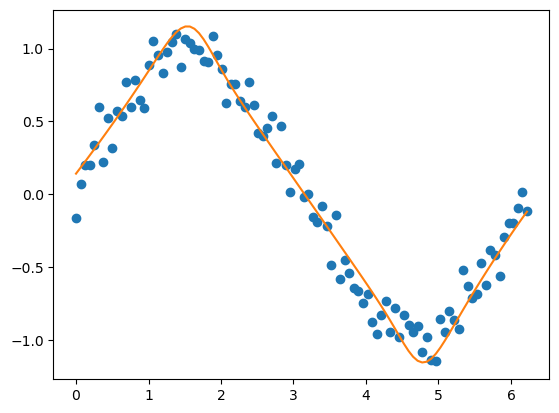

In [8]:
(fig, ax) = plt.subplots()
ax.scatter(x, y, color="C0")
ax.plot(x, yhat, color="C1")
plt.show()

## BICによるモデル選択

In [9]:
history = []
for K in range(1, 10):
    gmr = GaussianMixtureRegressor(n_components=K, init_params="k-means++")
    gmr.train(x, y)
    history.append(dict(K=K, BIC=gmr.bic(x, y)))

In [10]:
history

[{'K': 1, 'BIC': 547.7008257471788},
 {'K': 2, 'BIC': 495.4344720417198},
 {'K': 3, 'BIC': 334.3729240454827},
 {'K': 4, 'BIC': 345.7417194064268},
 {'K': 5, 'BIC': 346.5765476786067},
 {'K': 6, 'BIC': 379.4262105294759},
 {'K': 7, 'BIC': 384.0562031612451},
 {'K': 8, 'BIC': 397.2065385028184},
 {'K': 9, 'BIC': 423.40228791553363}]